<a href="https://colab.research.google.com/github/ElyorS/AI-application-system/blob/main/CRNN_for_IAM_32.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import os
import math
import string

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.backend import get_value, ctc_decode
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Nadam

from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
!mkdir lines
!mkdir ascii

mkdir: cannot create directory ‘lines’: File exists
mkdir: cannot create directory ‘ascii’: File exists


# Prepare dataset

In [12]:
# https://fki.tic.heia-fr.ch/DBs/iamDB/data/lines.tgz
!tar -xf /content/drive/MyDrive/AI_Application/lines.tar -C /content/lines
# https://fki.tic.heia-fr.ch/DBs/iamDB/data/ascii.tgz
!tar -xf /content/drive/MyDrive/AI_Application/ascii.tar -C /content/ascii

In [13]:
# Load labels

gt = pd.DataFrame(columns=['fn', 'value'])

with open('/content/ascii/lines.txt', 'r') as f:
  for index, row in enumerate(f):
    if row[0] == '#':
      continue
    row = row.split()
    gt.loc[gt.shape[0]] = (row[0], row[-1].replace('|', ' '))
gt.head(5)

,fn,value
0,a01-000u-00,A MOVE to stop Mr. Gaitskell from
1,a01-000u-01,nominating any more Labour life Peers
2,a01-000u-02,is to be made at a meeting of Labour
3,a01-000u-03,Ps tomorrow . Mr. Michael Foot has
4,a01-000u-04,put down a resolution on the subject


In [14]:
# Data preprocessing

def preprocess(img):
  for func in [resize_n_rotate, add_adaptiveThreshold]:
    img = func(img)
  return img


def resize_n_rotate(img, shape_to=(64, 800)):
  if img.shape[0] > shape_to[0] or img.shape[1] > shape_to[1]:
    shrink_multiplayer = min(math.floor(shape_to[0] / img.shape[0] * 100) / 100,
                             math.floor(shape_to[1] / img.shape[1] * 100) / 100)
    img = cv2.resize(img, None,
                     fx=shrink_multiplayer,
                     fy=shrink_multiplayer,
                     interpolation=cv2.INTER_AREA)

  img = cv2.copyMakeBorder(img, math.ceil(shape_to[0]/2) - math.ceil(img.shape[0]/2),
                           math.floor(shape_to[0]/2) - math.floor(img.shape[0]/2),
                           math.ceil(shape_to[1]/2) - math.ceil(img.shape[1]/2),
                           math.floor(shape_to[1]/2) - math.floor(img.shape[1]/2),
                           cv2.BORDER_CONSTANT, value=255)
  return cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)


def add_adaptiveThreshold(img):
  return cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 21, 10).astype('bool')


# Label encoding

def encode_text(texts):
  def _label_to_num(label, alphabet):
    label_num = []
    for ch in label:
      label_num.append(alphabet.find(ch))
    return np.array(label_num)

  alphabet = ''.join(sorted(pd.Series(texts).apply(list).apply(pd.Series).stack().unique()))

  nums = np.ones([len(texts), max([len(text) for text in texts])], dtype='int64') * len(alphabet)
  for i, text in enumerate(texts):
    nums[i][:len(text)] = _label_to_num(text, alphabet)

  return nums, alphabet

In [15]:
# Load and preprocess data

train_X, train_y = [], []

for sub_folder1 in tqdm(os.listdir('./lines')):
  for sub_folder2 in os.listdir(f'./lines/{sub_folder1}'):
    for sub_folder3 in os.listdir(f'./lines/{sub_folder1}/{sub_folder2}'):

      label = gt[gt.fn == sub_folder3[:sub_folder3.rfind('.')]].value.tolist()[0]
      if not any(list(map(lambda e: e not in string.ascii_letters + ',.\' ', label))):
        train_X.append(preprocess(cv2.imread(f'./lines/{sub_folder1}/{sub_folder2}/{sub_folder3}', 0)))
        train_y.append(gt[gt.fn == sub_folder3[:sub_folder3.rfind('.')]].value.tolist()[0])

train_X = np.array(train_X)
train_y, alphabet = encode_text(train_y)
alphabet

100%|██████████| 76/76 [01:02<00:00,  1.21it/s]


" ',.ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

In [16]:
train_X, val_X, train_y, val_y  = train_test_split(train_X, train_y, test_size=0.2, random_state=42)
train_X, test_X, train_y, test_y  = train_test_split(train_X, train_y, test_size=0.25, random_state=42)

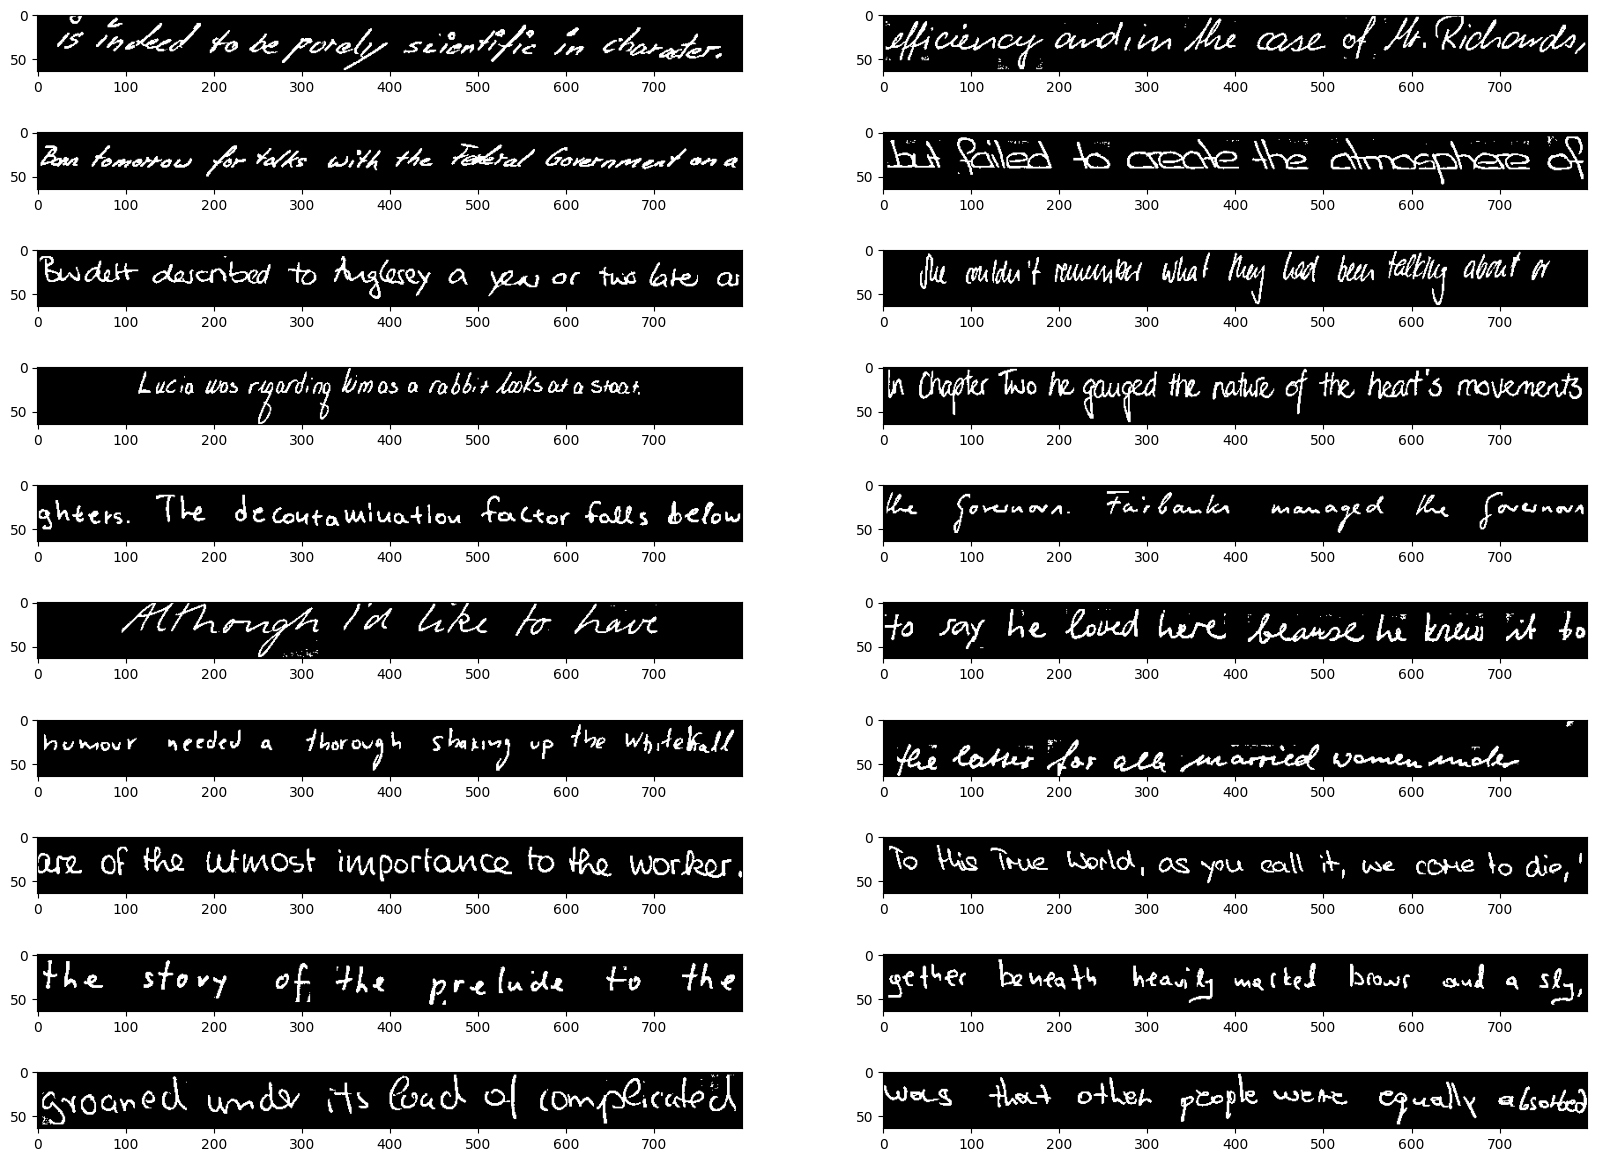

In [17]:
fig, axes = plt.subplots(figsize=(20, 15), ncols=2, nrows=10)

# Preprocess example

for i in range(10):
  for j in range(2):
    axes[i, j % 2].imshow(cv2.rotate(
        (train_X[i * 2 + j % 2]).astype(np.uint8),cv2.ROTATE_90_COUNTERCLOCKWISE),
        cmap='gray')

# Model

In [18]:
class CERMetric(tf.keras.metrics.Metric):
    """
    A custom Keras metric to compute the Character Error Rate
    """
    def __init__(self, name='CER_metric', **kwargs):
        super(CERMetric, self).__init__(name=name, **kwargs)
        self.cer_accumulator = self.add_weight(name="total_cer", initializer="zeros")
        self.counter = self.add_weight(name="cer_count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        input_shape = K.shape(y_pred)
        input_length = tf.ones(shape=input_shape[0]) * K.cast(input_shape[1], 'float32')

        decode, log = K.ctc_decode(y_pred, input_length, greedy=True)

        decode = K.ctc_label_dense_to_sparse(decode[0], K.cast(input_length, 'int32'))
        y_true_sparse = K.ctc_label_dense_to_sparse(y_true, K.cast(input_length, 'int32'))
        y_true_sparse = tf.sparse.retain(y_true_sparse, tf.not_equal(y_true_sparse.values, tf.math.reduce_max(y_true_sparse.values)))

        decode = tf.sparse.retain(decode, tf.not_equal(decode.values, -1))
        distance = tf.edit_distance(decode, y_true_sparse, normalize=True)

        self.cer_accumulator.assign_add(tf.reduce_sum(distance))
        self.counter.assign_add(K.cast(len(y_true), 'float32'))

    def result(self):
        return tf.math.divide_no_nan(self.cer_accumulator, self.counter)

    def reset_state(self):
        self.cer_accumulator.assign(0.0)
        self.counter.assign(0.0)


def CTCLoss(y_true, y_pred):
    """
    Compute the training-time loss value
    """
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = K.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [19]:
model = Sequential()

model.add(Conv2D(64, (5, 5), padding='same', activation=LeakyReLU(alpha=0.01), input_shape=(800, 64, 1)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (5, 5), padding='same', activation=LeakyReLU(alpha=0.01)))
model.add(MaxPooling2D((1, 2)))

model.add(Conv2D(128, (3, 3), padding='same', activation=LeakyReLU(alpha=0.01)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), padding='same', activation=LeakyReLU(alpha=0.01)))

model.add(Conv2D(256, (3, 3), padding='same', activation=LeakyReLU(alpha=0.01)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(512, (3, 3), padding='same', activation=LeakyReLU(alpha=0.01)))
model.add(MaxPooling2D((1, 2)))
model.add(BatchNormalization())

model.add(Conv2D(512, (3, 3), padding='same', activation=LeakyReLU(alpha=0.01)))
model.add(MaxPooling2D((1, 2)))

model.add(Reshape((100, 512)))

model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Bidirectional(LSTM(256, return_sequences=True)))

model.add(Dense(len(alphabet) + 1, activation='softmax')) # +1 for ctc blank

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 800, 64, 64)       1664      
                                                                 
 max_pooling2d (MaxPooling2  (None, 400, 32, 64)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 400, 32, 128)      204928    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 400, 16, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 400, 16, 128)      147584    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 200, 8, 128)       0

In [20]:
model.compile(optimizer=Nadam(learning_rate=0.001, clipnorm=1.0), loss=CTCLoss, metrics=[CERMetric()])

# Train model

In [21]:
history = model.fit(train_X, train_y, validation_data=(val_X, val_y),
                    epochs=75, batch_size=32,
                    callbacks=[EarlyStopping(patience=10, restore_best_weights=True, monitor='val_CER_metric'),
                              ReduceLROnPlateau(factor=0.5, min_lr=1e-5, patience=4, monitor='val_CER_metric')],
                    verbose=1)

Epoch 1/75
185/185 [==============================] - 97s 345ms/step - loss: 85.5021 - CER_metric: 0.6026 - val_loss: 208.7294 - val_CER_metric: 1.0000 - lr: 0.0010
Epoch 2/75
185/185 [==============================] - 57s 310ms/step - loss: 29.8043 - CER_metric: 0.2072 - val_loss: 96.7332 - val_CER_metric: 0.5491 - lr: 0.0010
Epoch 3/75
185/185 [==============================] - 61s 328ms/step - loss: 19.8947 - CER_metric: 0.1430 - val_loss: 26.1608 - val_CER_metric: 0.1820 - lr: 0.0010
Epoch 4/75
185/185 [==============================] - 60s 327ms/step - loss: 15.2075 - CER_metric: 0.1125 - val_loss: 19.9146 - val_CER_metric: 0.1382 - lr: 0.0010
Epoch 5/75
185/185 [==============================] - 61s 332ms/step - loss: 11.7081 - CER_metric: 0.0889 - val_loss: 19.0959 - val_CER_metric: 0.1263 - lr: 0.0010
Epoch 6/75
185/185 [==============================] - 61s 328ms/step - loss: 9.0745 - CER_metric: 0.0731 - val_loss: 18.4228 - val_CER_metric: 0.1227 - lr: 0.0010
Epoch 7/75
185/1

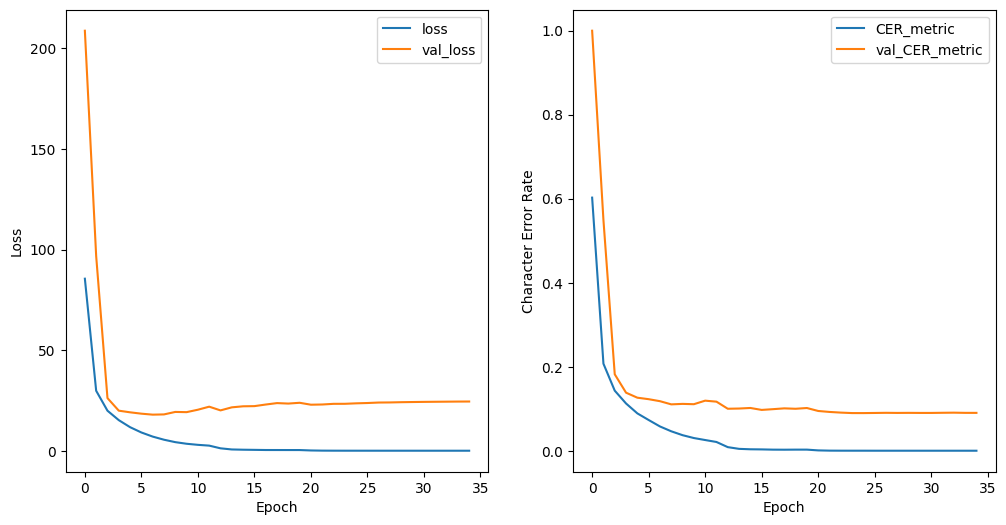

In [22]:
fig, axes = plt.subplots(figsize=(12, 6), ncols=2, nrows=1)

axes[0].plot(history.history['loss'], label='loss')
axes[0].plot(history.history['val_loss'], label='val_loss')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[1].plot(history.history['CER_metric'], label='CER_metric')
axes[1].plot(history.history['val_CER_metric'], label='val_CER_metric')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Character Error Rate")
axes[1].legend()

plt.show()

In [ ]:
model.save('./crnn.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# model = load_model('path/to/model', custom_objects={'CTCLoss' : CTCLoss, 'CERMetric': CERMetric})

## Model training results

In [23]:
# Test results: (loss, cer)

model.evaluate(test_X, test_y)

62/62 [==============================] - 10s 164ms/step - loss: 24.0605 - CER_metric: 0.0956


[24.06052017211914, 0.09563599526882172]

In [24]:
# Decode label for single image

def num_to_label(num, alphabet):
    text = ""
    for ch in num:
        if ch == len(alphabet): # ctc blank
          break
        else:
          text += alphabet[ch]
    return text


# Decode labels for softmax matrix

def decode_text(nums):
  values = get_value(
      ctc_decode(nums, input_length=np.ones(nums.shape[0])*nums.shape[1],
                 greedy=True)[0][0])

  texts = []
  for i in range(nums.shape[0]):
    value = values[i]
    texts.append(num_to_label(value[value >= 0], alphabet))
  return texts

In [25]:
predicts = model.predict(test_X)
predicts = decode_text(predicts)

62/62 [==============================] - 6s 82ms/step


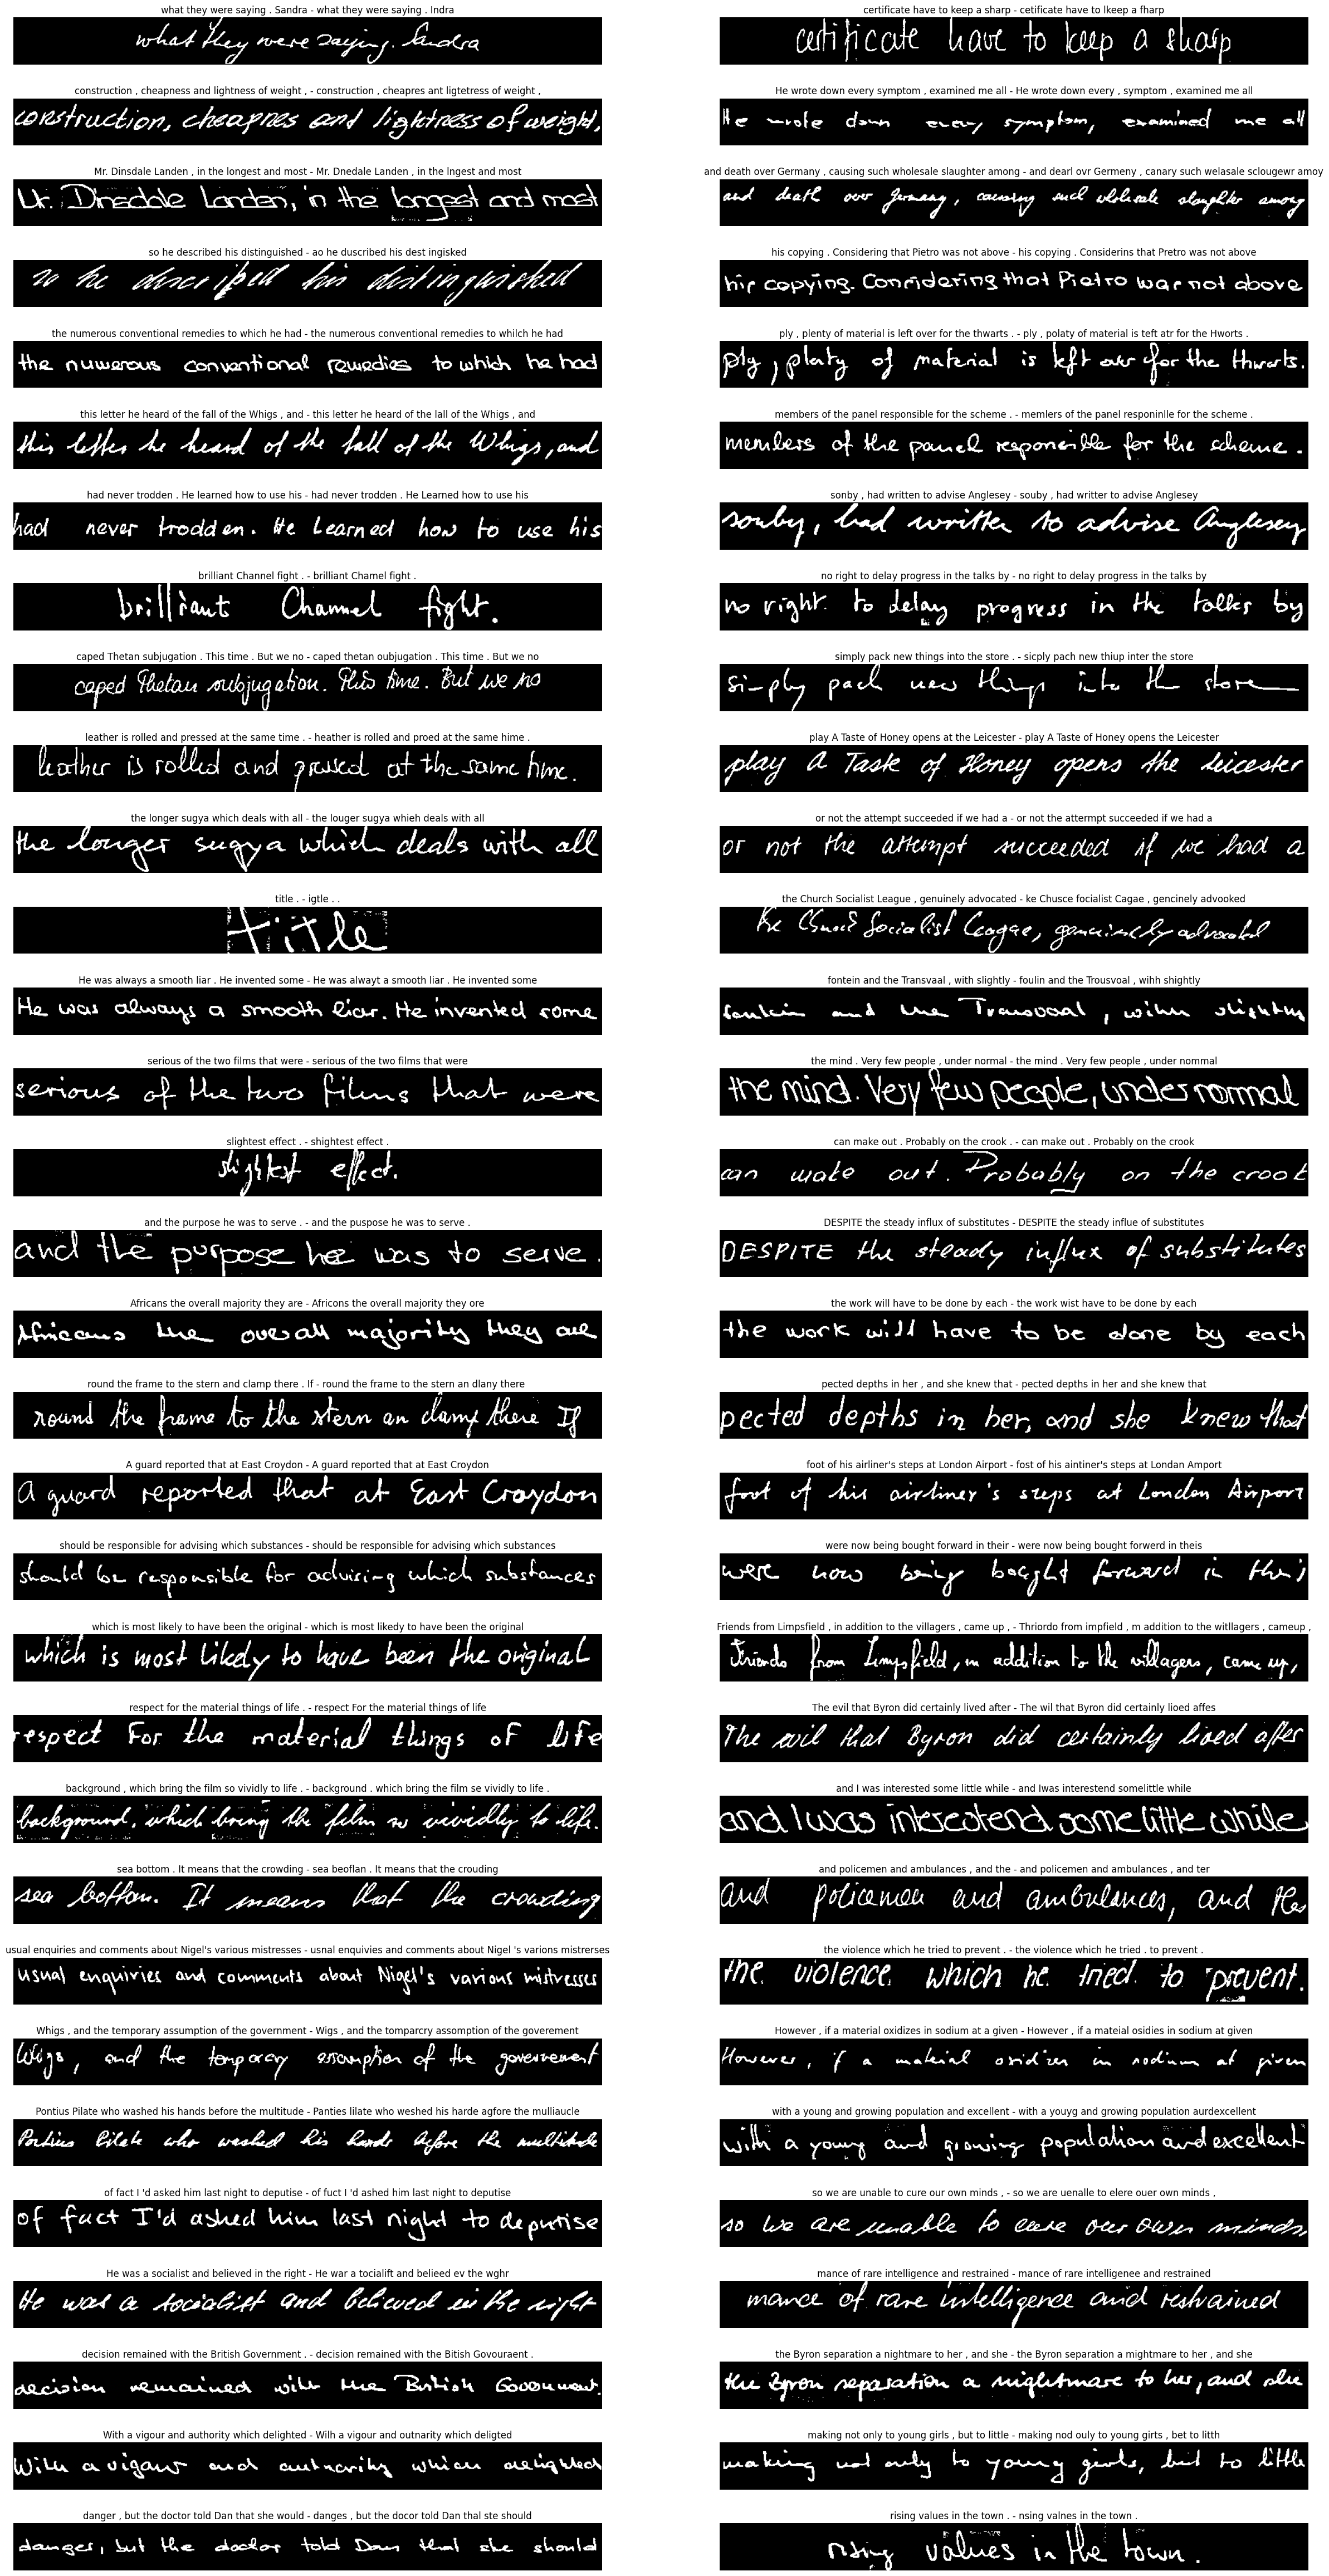

In [26]:
# Prediction results

fig, axes = plt.subplots(figsize=(30, 60), ncols=2, nrows=32)

test_X = test_X.astype('int')

# Title format: GT - Predict
for i in range(64):
  axes[i // 2, i % 2].imshow(cv2.rotate(
      (test_X[i]).astype(np.uint8),cv2.ROTATE_90_COUNTERCLOCKWISE),
      cmap='gray')
  axes[i // 2, i % 2].set_title(
      f'{num_to_label(test_y[i], alphabet)} - {predicts[i]}')
  axes[i // 2, i % 2].axis("off")